<a href="https://colab.research.google.com/github/rishubhkhurana/EVA/blob/master/S5/EVAS5v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Analysis -- First Version

1. Target -- Set up all the requisite code blocks. Try and achieve ~ 99% in 15 epochs.
2. Result -- Achieved Best Training Accuracy of 99.25 and Validation accuracy of 99.16
3. Analysis -- ~20K parameters. Higher capacity than required. Saw some overfitting in the last epochs. 

## Import Libs


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [0]:
!pip install torchsummary

In [0]:
from torchsummary import summary

## Transforms/Reading Dataset

In [0]:
train_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToTensor()])

In [0]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)

In [0]:
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training Dataset Mean: 0.13054245710372925
Training Dataset Mean: 0.30810782313346863


In [0]:
print(f"Testing Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

Testing Dataset Mean: 0.13054245710372925


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.3104802668094635


In [0]:
train_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1305,),(0.308,))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1305,),(0.308,))])

In [0]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)

In [0]:
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training Dataset Mean: 0.00167939648963511
Training Dataset Mean: 1.000349998474121


In [0]:
print(f"Testing Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.00167939648963511
Testing Dataset Mean: 1.0080528259277344


## Defining Data Loader


In [0]:
# defining the seed for reproducible
SEED = 99

torch.manual_seed(SEED)

# checking if the CUDA is available 

is_CUDA = torch.cuda.is_available()

if is_CUDA:
  dev = torch.device('cuda')
else:
  dev = torch.device('cpu')



In [0]:
BATCH_SIZE=128
EPOCHS=15

In [0]:
dataloader_args = dict(shuffle=True,batch_size=BATCH_SIZE,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=True,batch_size=BATCH_SIZE//2)
train_dl = DataLoader(train_data,**dataloader_args)

dataloader_args = dict(shuffle=False,batch_size=BATCH_SIZE*2,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=False,batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data,**dataloader_args)

In [0]:
x,y=next(iter(train_dl))

In [0]:
x.size(),y.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [0]:
torch.Tensor.stats = lambda x: (x.mean(),x.std())

In [0]:
x.stats()

(tensor(0.0281), tensor(1.0290))

In [0]:
type(x)

torch.Tensor

## Visualizing the data

In [0]:
def plot_img(img,axs=None,figsize=(6,6),visible=True):
  if axs is None:
    _,axs=plt.subplots(1,1,figsize=figsize)
  if not visible:
    #print("yesy")
    axs.set_xticks([])
    axs.set_yticks([])
  axs.imshow(img.numpy().squeeze(0),cmap='gray_r')
  
  

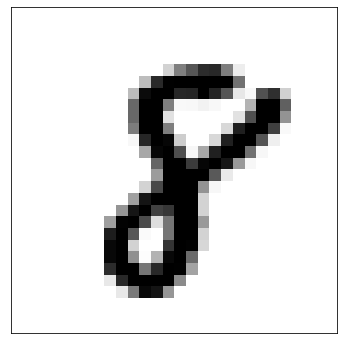

In [0]:
plot_img(x[0],visible=False)

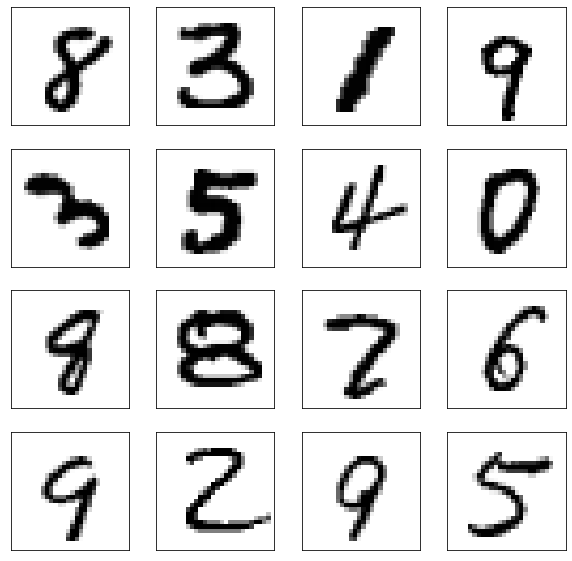

In [0]:
fig,axs = plt.subplots(4,4,figsize=(10,10))
for i,ax in enumerate(axs.ravel()):
  plot_img(x[i],axs=axs[i//4,i%4],visible=False)

## Defining Model

In [0]:
class Model(nn.Module):
  def __init__(self,p=0.0,use_bias=True):
    super().__init__()
    self.alllyrs=nn.Sequential()
    cblock1 = []
    cblock1.append(nn.Sequential(*[nn.Conv2d(1,16,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=26,RF=3
    cblock1.append(nn.Sequential(*[nn.Conv2d(16,32,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=24,RF=5
    self.cblock1 = nn.Sequential(*cblock1)
    tblock1=[]
    tblock1.append(nn.MaxPool2d((2,2))) # output_size=12, RF=6
    tblock1.append(nn.Sequential(*[nn.Conv2d(32,16,kernel_size=(1,1),stride=1,bias=use_bias),nn.ReLU()])) # output_size=12,RF=6
    self.tblock1=nn.Sequential(*tblock1)
    cblock2 = []
    cblock2.append(nn.Sequential(*[nn.Conv2d(16,16,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=10,RF=10
    cblock2.append(nn.Sequential(*[nn.Conv2d(16,16,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=8,RF=14
    cblock2.append(nn.Sequential(*[nn.Conv2d(16,16,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=6,RF=18
    cblock2.append(nn.Sequential(*[nn.Conv2d(16,16,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=4,RF=22
    cblock2.append(nn.Sequential(*[nn.Conv2d(16,16,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=4,RF=26

    self.cblock2 = nn.Sequential(*cblock2)
    tblock2=[]
    tblock2.append(nn.AdaptiveAvgPool2d((1,1)))
    tblock2.append(nn.Conv2d(16,10,kernel_size=(1,1),stride=1))
    self.tblock2=nn.Sequential(*tblock2)
  def forward(self,x):
    x = self.cblock1(x)
    x = self.tblock1(x)
    x = self.cblock2(x)
    x = self.tblock2(x)
    return F.log_softmax(x).squeeze().squeeze()


In [0]:
mod=Model().cuda()

In [0]:
#mod

In [0]:
summary(model=mod,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]             528
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
              ReLU-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           4,640
             ReLU-11           [-1, 32, 14, 14]               0
        MaxPool2d-12             [-1, 32, 7, 7]               0
           Conv2d-13             [-1, 16, 7, 7]             528
             ReLU-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Training Loop Design

In [0]:
# basic loop structure

def one_epoch(model,trn_dl,val_dl,opt,device='cpu'):
  # variables to keep track off during one epoch
  bcount=0
  tlosses=0
  tacc=0
  # put model in training mode
  model.train()
  # define a progress bar
  pbar = tqdm(trn_dl)
  # loop through every batch in dataloader
  for batch_index,(xb,yb) in enumerate(pbar):
    # move the data to cpu or gpu based on device arg
    xb,yb=xb.to(device),yb.to(device)
    bs = xb.shape[0]
    # clean the gradients of parameters computed in the previous batch
    opt.zero_grad()
    # predict the batch
    preds = model(xb)
    # compute batch loss
    loss = F.nll_loss(preds,yb)
    # append the current loss to list
    tlosses+=loss*bs
    # call back propagation
    loss.backward()
    # call the optimization step
    opt.step()
    # compute the current model accuracy
    y_preds=preds.argmax(dim=1,keepdim=True)
    # compute current accuracy of the training batch and add it to the total count of accurate results
    tacc+= y_preds.eq(yb.view_as(y_preds)).sum().item()
    bcount+=bs
    # add progress bar description with current batch loss and moving average of training accuracy
    pbar.set_description(desc=f'Loss={loss.item():.3f} batch-index={batch_index} Accuracy={100*tacc/bcount:0.2f}')
  
  # compute the updated training loss and accuracy for entire batch
  tlosses/=bcount
  tacc/=bcount

  # loop through validation data and compute the metrics on validation data
  model.eval()
  vloss=0
  vacc=0
  vcount=0
  with torch.no_grad():
    for xb,yb in tqdm(val_dl):
      bs = xb.shape[0]
      xb,yb = xb.to(device),yb.to(device)
      preds = model(xb)
      loss = F.nll_loss(preds,yb,reduction='sum')
      y_preds = preds.argmax(dim=1,keepdim=True)
      vacc+=y_preds.eq(yb.view_as(y_preds)).sum().item()
      vcount+=bs
      vloss+=loss.item()
  vloss/=vcount
  vacc/=vcount
  return {'TrainingLoss':tlosses,'ValidationLoss':vloss,'TrainingAcc':tacc,'ValidationAcc':vacc}








## Training the Model

In [0]:
mod=Model().cuda()
opt = optim.SGD(mod.parameters(),lr=0.05,momentum=0.9)
for e in range(EPOCHS):
  ldict=one_epoch(mod,train_dl,test_dl,opt,device=dev)
  print(f'\nEpoch:{e}--> Training Loss:{ldict["TrainingLoss"]:.3f}, Validation Loss:{ldict["ValidationLoss"]:.3f}\n')
  print(f'Training Accuracy:{100*ldict["TrainingAcc"]:.3f}, Validation Accuracy:{100*ldict["ValidationAcc"]:.3f}\n')

  

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:0--> Training Loss:1.618, Validation Loss:0.297

Training Accuracy:38.832, Validation Accuracy:90.920



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.134, Validation Loss:0.067

Training Accuracy:96.045, Validation Accuracy:98.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.078, Validation Loss:0.061

Training Accuracy:97.710, Validation Accuracy:98.090



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.063, Validation Loss:0.050

Training Accuracy:98.128, Validation Accuracy:98.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.052, Validation Loss:0.052

Training Accuracy:98.433, Validation Accuracy:98.590



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:5--> Training Loss:0.046, Validation Loss:0.046

Training Accuracy:98.583, Validation Accuracy:98.630



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.037, Validation Loss:0.035

Training Accuracy:98.920, Validation Accuracy:98.900



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.036, Validation Loss:0.033

Training Accuracy:98.882, Validation Accuracy:98.990



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.032, Validation Loss:0.031

Training Accuracy:99.057, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.032, Validation Loss:0.036

Training Accuracy:99.075, Validation Accuracy:99.000



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:10--> Training Loss:0.031, Validation Loss:0.044

Training Accuracy:99.057, Validation Accuracy:98.740



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.028, Validation Loss:0.033

Training Accuracy:99.123, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.025, Validation Loss:0.032

Training Accuracy:99.252, Validation Accuracy:99.160



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.024, Validation Loss:0.043

Training Accuracy:99.262, Validation Accuracy:98.840



100%|██████████| 40/40 [00:01<00:00, 27.03it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.040

Training Accuracy:99.257, Validation Accuracy:98.840

